<a href="https://colab.research.google.com/github/AnIsAsPe/Regresion-Robusta-para-estimar-tiempo-de-respuesta-de-un-servicio-de-emergencia/blob/main/Notebooks/1_Response_time_Paris_Fire_Brigade_202505.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cargar bibiliotecas y funciones

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler         # solamente para la comparación da la improtancia entre variables explicativas

from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def correlacion(dataframe, grafica=True, matrix=True, tamaño =(6, 4)):
    '''
    Funcion para obtener la matriz de correlacion y visualizarla en mapa de calor.
    '''
    corr=dataframe.corr()
    if grafica==True:
      fig = plt.figure(figsize = tamaño)
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm",
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(),
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

In [5]:
def describe_datos(df):
    """
    Función para describir un DataFrame de pandas.

    Devuelve:
    --------
    DataFrame
        Devuelve un DataFrame con la descripción de cada columna, incluyendo:
    (1) Tipo de columna, (2) Número de valores nulos, (3) Porcentaje de valores nulos
    (4) Número de valores únicos y (5) Valores únicos

    """

    unicos =[]
    for col in df:
        unicos.append(df[col].unique())
    unicos = pd.Series(unicos, index=df.columns)
    descripcion = pd.concat(
        [
            df.dtypes,
            df.isna().sum(),
            round(df.isna().sum()/len(df)*100, 1),
            df.nunique(),
            unicos
        ],
        axis=1
    )

    descripcion.columns = ['dtypes', 'null', '%null', 'nunique', 'unique']
    return descripcion

In [6]:
def round_lat_lon_columns(df, columns, digitos):
    """
    Redondea las columnas de latitud y longitud especificadas en un DataFrame.

    Parameters:
    df (pd.DataFrame): El DataFrame de entrada.
    columns (list): Una lista de nombres de columnas a redondear.
    digitos (int): El número de decimales a redondear

    Returns:
    pd.DataFrame: El DataFrame con las columnas redondeadas.
    """
    df = df.copy()
    for col in columns:
        if col in df.columns:
            df[col] = df[col].round(digitos)
    return df

In [7]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia Haversine entre dos puntos en la tierra.

    Parameteros:
    lat1 (pd.Series or float): Latitud de punto inicial en grados.
    lon1 (pd.Series or float): Longitud del punto inicial en grados.
    lat2 (pd.Series or float): Latitud del punto final en grados.
    lon2 (pd.Series or float): Longitud del punto final en grados.

    Devuelve:
    pd.Series or float: Haversine distance(s) in kilometers.
    """
    R = 6371  # Radius of Earth in kilometers

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance.round(4)

In [8]:
# Function to plot categorical data with relative frequency
def plot_categorical_relative_frequency(df, column, fig_size=(15,5)):
    counts = df[column].value_counts()
    plt.figure(figsize=fig_size)
    # Orden basado en la frecuencia
    order = counts.index
    counts.plot(kind='bar')
    plt.title(f'Categorías de {column} ')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

def plot_categorical_boxplot(df, column, fig_size=(15,5)):
    counts = df[column].value_counts()
    plt.figure(figsize=fig_size)
    # Get the order of categories based on frequency from the previous step
    order = df[column].value_counts().index.tolist()
    sns.boxplot(x=column, y='delta departure-presentation', data=df, showfliers=False, order=order)
    plt.title(f'Delta Departure-Presentation por {column} ')
    plt.xlabel(column)
    plt.ylabel('Delta Departure-Presentation')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

# Lectura datos y selección de características

__Cargar etiquetas__

In [9]:
# Variables respuesta
Ys = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/y_train.csv',
                     index_col=[0], sep=',',)
print(Ys.shape)
Ys.head(2)

(219337, 3)


,delta selection-departure,delta departure-presentation,delta selection-presentation
emergency vehicle selection,,,
5105452,86,324,410
4720915,164,297,461


In [10]:
# Se puede verificar si la última columna es la suma de las otras dos
(Ys.iloc[:,0] + Ys.iloc[:,1] == Ys.iloc[:,2]).sum()==len(Ys)

np.True_

Nos vamos a concentrar en el tiempo desde la salida del vehículo hasta la presentación en el lugar del siniestro

__Cargar características__

In [11]:
# Conjunto de caracteristicas (X)
X = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/x_train.csv',
                sep=',', index_col=[0], parse_dates=['selection time'] )
print(X.shape)
X.head(2)

(219337, 25)


,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,...,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,
5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,...,2027,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8
4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,PSE,...,28233,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2


In [12]:
describe_datos(X)

,dtypes,null,%null,nunique,unique
intervention,int64,0,0.0,200894,"[13264186, 12663715, 13675521, 12695745, 13698..."
alert reason category,int64,0,0.0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
alert reason,int64,0,0.0,126,"[2162, 2124, 2163, 2112, 2711, 2113, 2135, 212..."
intervention on public roads,int64,0,0.0,2,"[0, 1]"
floor,int64,0,0.0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,float64,12710,5.8,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
longitude intervention,float64,0,0.0,83484,"[2.284796, 2.247464, 2.258328, 2.393832, 2.458..."
latitude intervention,float64,0,0.0,74503,"[48.879669, 48.818191, 48.836759, 48.776526, 4..."
emergency vehicle,int64,0,0.0,749,"[4511, 4327, 4509, 5731, 5623, 4319, 4215, 588..."
emergency vehicle type,object,0,0.0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."


La cantidad de intervenciones en los datos no es igual a la cantidad de vehículos, De manera que existen intervenciones que son atendidas por más de un vehiculo de emergencia

In [13]:
# Vamos a redondear a 4 decimales latitud y longitud (11 mts de aproximación) lo que es suficiente para ubicaciones especificasya que un GPS da coordadas demasiado precisas
# 6 decimales son excesivos (la precisión es de 11 cm), vamos a quedarnos con una precisión

lat_long_cols = ['latitude before departure', 'longitude before departure',
                 'latitude intervention', 'longitude intervention']

X = round_lat_lon_columns(X, lat_long_cols, 4 )



In [14]:
X.loc[5105452, 'OSRM response']

'{"code":"Ok","routes":[{"geometry":"}yjiH}x}L_D}Fb@c@dEQb@o@fDvF`InO`Ae@hDfBxE~A","legs":[{"steps":[],"distance":952.5,"duration":105.8,"summary":"","weight":105.8}],"distance":952.5,"duration":105.8,"weight_name":"routability","weight":105.8}],"waypoints":[{"hint":"-iAAgP___39gAAAA8QAAAAAAAAAnAAAAEPiFQnllyUIAAAAAZMLaQWAAAADxAAAAAAAAACcAAABIBQAAOugiANrs6QK16SIA2uvpAgAA3wInhS-p","distance":39.792677,"name":"Boulevard de l\'Yser","location":[2.287674,48.884954]},{"hint":"89sMgP___38CAAAAQgAAAEsAAABeAAAA6UsqQIbljUJxZadCA0jRQgIAAABCAAAASwAAAF4AAABIBQAA09wiAD3Y6QL83CIANdjpAgEATwwnhS-p","distance":3.136462,"name":"Boulevard Gouvion-Saint-Cyr","location":[2.284755,48.879677]}]}'

In [15]:
X['departed from its rescue center'].value_counts()

,count
departed from its rescue center,
1,214434
0,4903


In [16]:
X['status preceding selection'].value_counts()

,count
status preceding selection,
Rentré,214434
Disponible,4903


In [17]:
mask_in_rescue_center = X['departed from its rescue center']==1

display('Rescue Centers Unicos',
        X[mask_in_rescue_center]['rescue center'].nunique(),
        X[mask_in_rescue_center]['latitude before departure'].nunique(),
        X[mask_in_rescue_center]['longitude before departure'].nunique())

'Rescue Centers Unicos'

94

87

87

No todos los veículos que salieron de un 'rescue center', salieron del que oficialemnte les correspondía, por tanto no se usará el 'campo rescue center' por ser más una variable administrativa que operacional.

In [18]:
# Borrar columnas que no utilizaremos

col_borrar = [
    'intervention',  #identificador de la intervención

    # Redundantes
    'date key sélection',
    'time key sélection',         # incluidas en 'selection time'
    'emergency vehicle',          # 749 categorias, resumidas en 75 'emergency vehicle type'
    'alert reason',               # 126 categorías, resumidas en 9 'alert reason category'
    'status preceding selection', # igual a 'departed from its rescue center'

    # Rutas
    'OSRM response',                              # ruta estimada
    'GPS tracks departure-presentation',          # posiciones gps en la ruta
    'GPS tracks datetime departure-presentation', # tiempo de medición pesisiones gps en la ruta

    # Variable no relaccionadas con delta departure-presentation
    'rescue center',               # id, variable administrativa más que operacional
    'delta status preceding selection-selection',
    'delta position gps previous departure-departure'
            ]
X = X.drop(columns= col_borrar)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219337 entries, 5105452 to 4868867
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   alert reason category            219337 non-null  int64         
 1   intervention on public roads     219337 non-null  int64         
 2   floor                            219337 non-null  int64         
 3   location of the event            206627 non-null  float64       
 4   longitude intervention           219337 non-null  float64       
 5   latitude intervention            219337 non-null  float64       
 6   emergency vehicle type           219337 non-null  object        
 7   selection time                   219337 non-null  datetime64[ns]
 8   departed from its rescue center  219337 non-null  int64         
 9   longitude before departure       219337 non-null  float64       
 10  latitude before departure        219337 no

__Unir caracteristicas con étiquetas__

In [19]:
df = pd.concat([X,  Ys['delta departure-presentation']], axis=1)
print(df.shape)


(219337, 14)


<h2> Idetificación del tipo de variable de cada columna

Comparamos el tipo de cada columna con la documentación de los parámetros de entrada en [la documentación provista por el Challenge](https://paris-fire-brigade.github.io/data-challenge/challenge.html)

In [20]:
categorical_cols = [
    'alert reason category','location of the event','emergency vehicle type',
    ]
booleanas_cols=['intervention on public roads', 'departed from its rescue center']
df[booleanas_cols]=df[booleanas_cols].astype('bool')
df[categorical_cols] = df[categorical_cols].astype('object')
describe_datos(df)

,dtypes,null,%null,nunique,unique
alert reason category,object,0,0.0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
intervention on public roads,bool,0,0.0,2,"[False, True]"
floor,int64,0,0.0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,object,12710,5.8,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
longitude intervention,float64,0,0.0,4361,"[2.2848, 2.2475, 2.2583, 2.3938, 2.4586, 2.349..."
latitude intervention,float64,0,0.0,2696,"[48.8797, 48.8182, 48.8368, 48.7765, 48.8758, ..."
emergency vehicle type,object,0,0.0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."
selection time,datetime64[ns],0,0.0,219285,"[2018-07-08 19:02:43.990000, 2018-01-04 09:02:..."
departed from its rescue center,bool,0,0.0,2,"[True, False]"
longitude before departure,float64,0,0.0,1932,"[2.2881, 2.2685, 2.2729, 2.3889, 2.4393, 2.343..."


# Creación de nuevas variables

## A partir de 'selection time'

In [21]:
df['hour'] = (df['selection time'].dt.hour +           \
              df['selection time'].dt.minute / 60 +    \
              df['selection time'].dt.second / 3600)
df['day_of_week'] = df['selection time'].dt.day_name()
df['weekend'] = df['selection time'].dt.dayofweek > 4
df['month'] = df['selection time'].dt.month_name()

Rush hour: variable binaria para identificar eventos en horas pico

In [22]:
df['rush hour'] = False

# Poner como indice 'selection time'
df = df.reset_index()
df = df.set_index('selection time')

# identificar el indice de los registros de eventos en hora pico
pico_am = df.index.indexer_between_time('6:30','9:30')
pico_pm = df.index.indexer_between_time('16:00','19:00')
horas_pico_index= np.concatenate((pico_am, pico_pm))

# cambiar el valor de 'rush hour' a uno cuando sea horas pico
df.iloc[list(horas_pico_index),-1] = True

# Regresar a 0 el valor para los días sabados y domingos
df['rush hour']= np.where(df['weekend']==True, False, df['rush hour'])

# Regresar emerency vehicle selection como indice
df = df.reset_index()
df = df.set_index('emergency vehicle selection')

In [23]:
France_hollidays = {
    '02/01/2018': "New Year's Day",
    '02/04/2018': "Easter Monday",
    '01/05/2018': "Labor Day",
    '08/05/2018': "WWII Victory Day",
    '10/05/2018': "Ascension Day",
    '21/05/2018': "Whit Monday",
    '14/07/2018': "Bastille Day",
    '15/08/2018': "Assumtion of Mary",
    '01/11/2018': "All' Saints' Day",
    '11/11/2018': "Armistice Day",
    '25/12/1973': "Christmas Day",
}
# https://www.timeanddate.com/holidays/france/2018?hol=9

In [24]:
# prompt: # prompt: create column in df based in 'selection time' column and the dictionary France_hollidays

df['is_holiday'] = df['selection time'].dt.strftime('%d/%m/%Y').isin(France_hollidays.keys())

In [25]:
df[['selection time', 'hour', 'day_of_week', 'month', 'rush hour','weekend', 'is_holiday']].head()

,selection time,hour,day_of_week,month,rush hour,weekend,is_holiday
emergency vehicle selection,,,,,,,
5105452,2018-07-08 19:02:43.990,19.045278,Sunday,July,False,True,False
4720915,2018-01-04 09:02:59.470,9.049722,Thursday,January,True,False,False
5365374,2018-11-16 10:11:47.777,10.196389,Friday,November,False,False,False
4741586,2018-01-15 00:38:46.820,0.646111,Monday,January,False,False,False
5381209,2018-11-24 00:34:26.017,0.573889,Saturday,November,False,True,False


## A partir de longitud, latitud y distancia OSMR

Primero calculamos la Distancia Haversine  partir de latitud y longitud de salida y llegada del vehiculo de emergencia.
Despues anlizaremos la relación con la distancia OSMR


In [26]:
import folium

# Creamos un mapa centrado en el promedio de las coordenadas
map_center = [df['latitude intervention'].mean(), df['longitude intervention'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# Para una muestra de 1000 registros marcamos en el mapa el punto de salida,
# de la intervención y los unimos con una linea
for _, row in df.sample(min(1000, len(df))).iterrows():
    # Localización de la emergencia
    folium.CircleMarker(
        location=[row['latitude intervention'], row['longitude intervention']],
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

    # Punto de salida
    folium.CircleMarker(
        location=[row['latitude before departure'], row['longitude before departure']],
        radius=1,
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(m)
    # Linea que conecta el punto de salida con el de la intervención
    folium.PolyLine(
        locations=[[row['latitude before departure'], row['longitude before departure']],
                   [row['latitude intervention'], row['longitude intervention']]],
        color='black',
        weight=1
    ).add_to(m)


# Display the map
m

In [27]:
df['haversine_distance_km'] = haversine(
    df['latitude intervention'],
    df['longitude intervention'],
    df['latitude before departure'],
    df['longitude before departure']
)

df.haversine_distance_km.describe()

,haversine_distance_km
count,219337.000000
mean,1.472844
std,1.134139
min,0.007300
25%,0.741600
50%,1.209100
75%,1.899200
max,30.936300


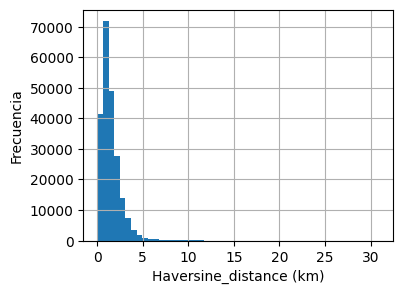

In [28]:
plt.figure(figsize=(4, 3))
df.haversine_distance_km.hist(bins=50)
plt.xlabel('Haversine_distance (km)')
plt.ylabel('Frecuencia')
plt.show()

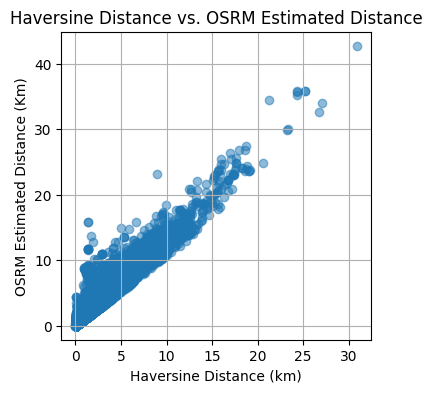

Correlación entre Haversine Distance y OSRM Estimated Distance: 0.9385


In [29]:
plt.figure(figsize=(4, 4))
plt.scatter(df['haversine_distance_km'], df['OSRM estimated distance']/1000, alpha=0.5)
plt.title('Haversine Distance vs. OSRM Estimated Distance')
plt.xlabel('Haversine Distance (km)')
plt.ylabel('OSRM Estimated Distance (Km)')
plt.grid(True)
plt.show()

correlation = df['haversine_distance_km'].corr(df['OSRM estimated distance'])
print(f"Correlación entre Haversine Distance y OSRM Estimated Distance: {correlation:.4f}")

In [30]:
# Calculamos la relación entre la distancia Real y a Vuelo
# Esta diferencia nos proporciona información sobre la complejidad y conectividad del camino.

# Es necesario unificar las unidades.

road_complexity_factor =  (df['OSRM estimated distance'] / 1000) / df['haversine_distance_km']
road_complexity_factor.describe()


,0
count,219337.000000
mean,1.676234
std,1.001478
min,0.021858
25%,1.303731
50%,1.485043
75%,1.774948
max,123.006849


In [31]:

def crea_row_complexity_category(df):
    """
    1. Calcula el Ratio de Complejidad (Distancia Real / Distancia Vuelo).
    2. Maneja divisiones por cero.
    3. Categoriza en Bajo/Medio/Alto para el modelo.
    """
    df = df.copy()

    # --- PASO 1: CÁLCULO DEL RATIO ---
    # Sumamos un epsilon (1e-6) al denominador para evitar divisiones por cero si origen == destino
    road_complexity_factor = (
        (df['OSRM estimated distance'] / 1000) /
        (df['haversine_distance_km'] + 1e-6)
    )

    # --- PASO 2: DEFINICIÓN DE REGLAS ---
    condiciones = [
        road_complexity_factor < 1.3,
        road_complexity_factor < 1.8
    ]

    etiquetas = ['Low_Complexity', 'Medium_Complexity']

    # --- PASO 3: CATEGORIZACIÓN ---
    # Si no cumple ninguna condición anterior (es decir, es >= 1.8), le pone 'High_Complexity'
    df['row_complexity_category'] = np.select(condiciones, etiquetas, default='High_Complexity')

    return df

In [32]:
df = crea_row_complexity_category(df)
df['row_complexity_category'].value_counts()

,count
row_complexity_category,
Medium_Complexity,113963
Low_Complexity,53542
High_Complexity,51832


## Puntos de salida
Variable categorica que identifica las coordenadas de salida.

In [33]:
# Redondeamos latitud y longitud de salida a 4 dígitos (aproxima el lugar con un error de 110 mts)
lat_round = X['latitude before departure'].round(4)
lon_round = X['longitude before departure'].round(4)

# starting_point_aux = (lat_round.astype(str) + '_' + lon_round.astype(str))
# df['starting_point'] = np.where(df['departed from its rescue center'], starting_point_aux, 'Other')

df['starting_point']  = (lat_round.astype(str) + '_' + lon_round.astype(str))
df['starting_point'].value_counts()


,count
starting_point,
48.8722_2.4037,6112
48.8911_2.3328,5966
48.8847_2.2881,5265
48.8476_2.3843,5204
48.8312_2.318,5122
...,...
48.8483_2.2673,1
48.9362_2.3627,1
48.8392_2.3206,1


In [34]:
df.drop(
    columns=['latitude intervention','longitude intervention',
             'latitude before departure','longitude before departure',
             'selection time'],
    inplace=True
)

# Manejo de Valores Nulos

In [35]:
describe_datos(df)

,dtypes,null,%null,nunique,unique
alert reason category,object,0,0.0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
intervention on public roads,bool,0,0.0,2,"[False, True]"
floor,int64,0,0.0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,object,12710,5.8,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
emergency vehicle type,object,0,0.0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."
departed from its rescue center,bool,0,0.0,2,"[True, False]"
OSRM estimated distance,float64,0,0.0,48461,"[952.5, 2238.5, 3026.4, 1934.2, 2706.7, 1685.8..."
OSRM estimated duration,float64,0,0.0,8236,"[105.8, 243.2, 295.4, 166.6, 262.6, 187.7, 301..."
delta departure-presentation,int64,0,0.0,1909,"[324, 297, 365, 160, 523, 419, 452, 404, 411, ..."
hour,float64,0,0.0,76301,"[19.04527777777778, 9.049722222222222, 10.1963..."


In [36]:
df['location of the event'].value_counts(dropna=False)/len(df)*100

,count
location of the event,
139.0,23.266024
136.0,20.242823
148.0,14.588054
NaN,5.794736
149.0,4.515882
...,...
290.0,0.000456
265.0,0.000456
302.0,0.000456



**Alternativas**
- Borrar esos renglones,
- borrar esa variable,
- imputar valores:
   - ¿remplazar por ceros?
   - ¿reemplazar por una medida de tendencia central?
   - ¿a parir del conocimiento que nos proporcionan las demás variables?

In [37]:
moda = df['location of the event'].mode().values[0]
df['location of the event'] = df['location of the event'].infer_objects(copy=False).fillna(moda)
# regresar a tipo objeto, para distinguirla como variable categórica
df['location of the event'] = df['location of the event'].astype('int').astype('object')

In [38]:
df.isna().sum()

,0
alert reason category,0
intervention on public roads,0
floor,0
location of the event,0
emergency vehicle type,0
departed from its rescue center,0
OSRM estimated distance,0
OSRM estimated duration,0
delta departure-presentation,0
hour,0


# Exploración y selección de variables

## Variables booleanas

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219337 entries, 5105452 to 4868867
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   alert reason category            219337 non-null  object 
 1   intervention on public roads     219337 non-null  bool   
 2   floor                            219337 non-null  int64  
 3   location of the event            219337 non-null  object 
 4   emergency vehicle type           219337 non-null  object 
 5   departed from its rescue center  219337 non-null  bool   
 6   OSRM estimated distance          219337 non-null  float64
 7   OSRM estimated duration          219337 non-null  float64
 8   delta departure-presentation     219337 non-null  int64  
 9   hour                             219337 non-null  float64
 10  day_of_week                      219337 non-null  object 
 11  weekend                          219337 non-null  bool   
 12  

In [40]:
booleanas_cols = df.select_dtypes(include='bool').columns.tolist()
booleanas_cols

['intervention on public roads',
 'departed from its rescue center',
 'weekend',
 'rush hour',
 'is_holiday']

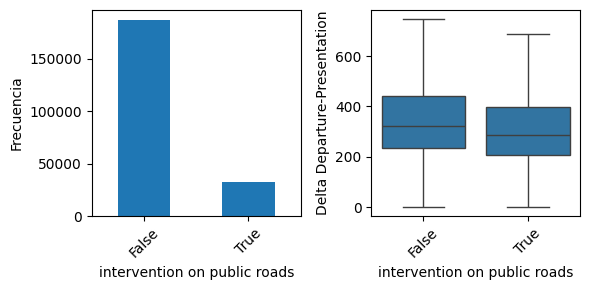

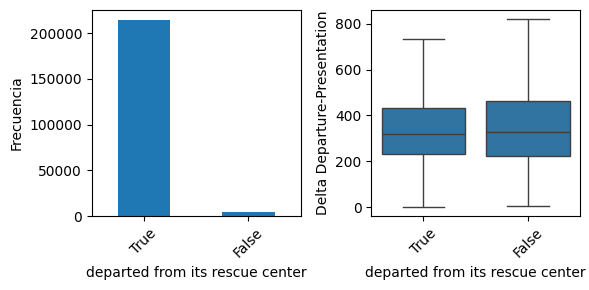

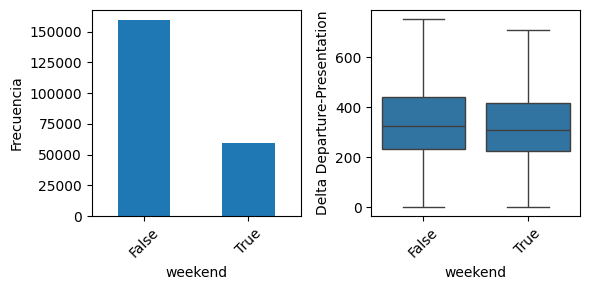

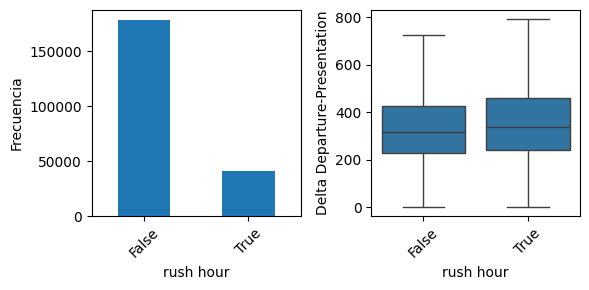

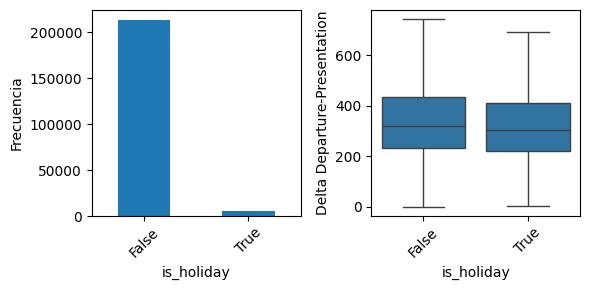

In [41]:
for column in booleanas_cols:
    fig, axes = plt.subplots(1, 2, figsize=(6, 3)) # Create a figure with 1 row and 2 columns

    # Plot relative frequency
    counts = df[column].value_counts()
    counts.plot(kind='bar', ax=axes[0])
    # axes[0].set_title(f'Categorías de {column} ')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frecuencia')
    axes[0].tick_params(axis='x', rotation=45)


    # Plot boxplot
    order = counts.index.tolist() # Use the same order as the frequency plot
    sns.boxplot(x=column, y='delta departure-presentation', data=df, showfliers=False, order=order, ax=axes[1])
    # axes[1].set_title(f'Delta Departure-Presentation por {column} ')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Delta Departure-Presentation')
    axes[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

## Numéricas

Identificar y eliminar variables:

1. **No relevantes**: Análisis de correlación de las explicativas(X) con la etiqueta (y)


2. **Redundantes**: Análisis de correlación entre las variables explicativas (X)

In [42]:
numericas_cols = list(df.select_dtypes(include=['int64', 'float64']).columns)
numericas_cols

['floor',
 'OSRM estimated distance',
 'OSRM estimated duration',
 'delta departure-presentation',
 'hour',
 'haversine_distance_km']

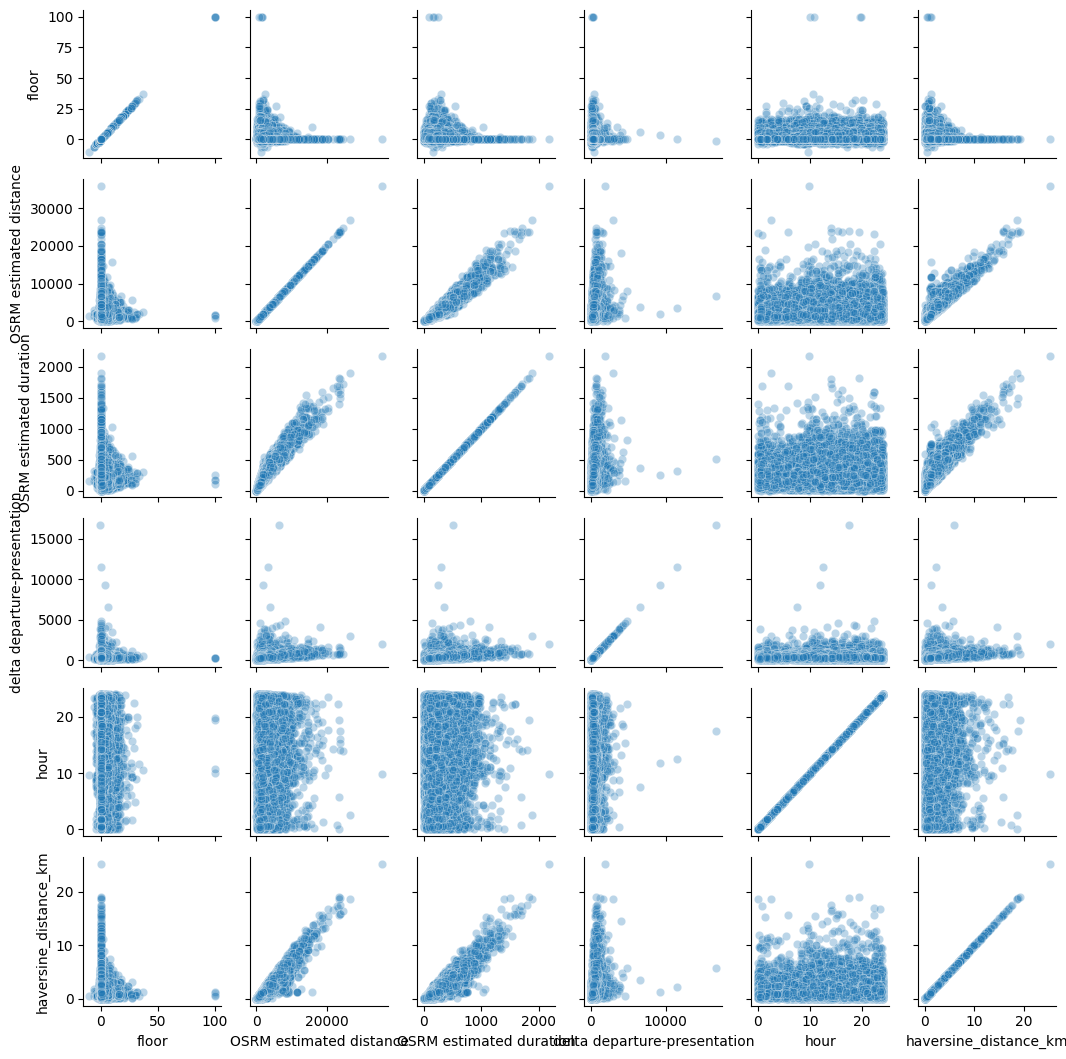

In [43]:
g = sns.PairGrid(df[numericas_cols].sample(frac=.25), height= 1.8)
g.map(sns.scatterplot, alpha=0.3)
plt.show()

<h2> ¿Hay variables que no son relevantes para la predicción de la variable respuesta?

In [44]:
corr_y = df[numericas_cols].corr()['delta departure-presentation']
corr_y.sort_values()

,delta departure-presentation
hour,-0.019854
floor,0.002170
haversine_distance_km,0.441527
OSRM estimated duration,0.446742
OSRM estimated distance,0.449922
delta departure-presentation,1.000000


In [45]:
no_relevantes = corr_y.loc[corr_y.abs()<0.1].index.to_list()
no_relevantes

['floor', 'hour']

<h2> ¿Hay variables redundantes entre las variables explicativas?

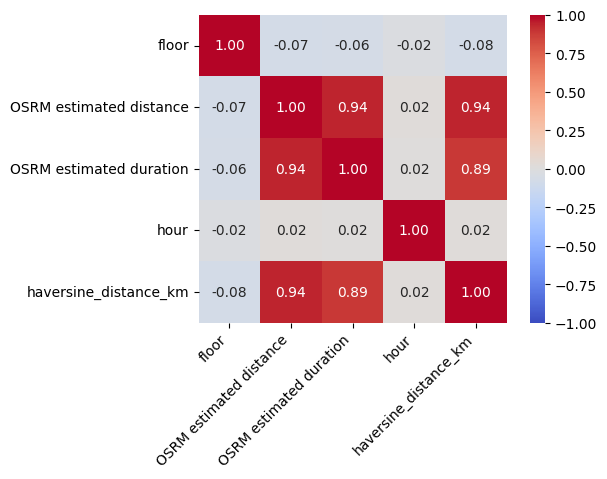

In [46]:
# correlacion de las características numéricas en el conjunto X
corr_matrix = correlacion(df[numericas_cols].drop('delta departure-presentation', axis=1))


In [47]:
#Identificar variables redundantes

# Triangulo superior de la matriz de correlación en números absolutos
celda_sobre_diagonal_ppal = np.triu(np.ones_like(corr_matrix), 1).astype(bool)
triangulo_sup = corr_matrix.where(celda_sobre_diagonal_ppal).abs()


# Encontrar las columnas donde la correlación es 1
redundantes = [column for column in triangulo_sup.columns
          if any(triangulo_sup[column] >= .7)]
redundantes

['OSRM estimated duration', 'haversine_distance_km']

In [48]:
df = df.drop(redundantes + no_relevantes, axis=1)

In [49]:
df.columns

Index(['alert reason category', 'intervention on public roads',
       'location of the event', 'emergency vehicle type',
       'departed from its rescue center', 'OSRM estimated distance',
       'delta departure-presentation', 'day_of_week', 'weekend', 'month',
       'rush hour', 'is_holiday', 'row_complexity_category', 'starting_point'],
      dtype='object')

##  Variables categóricas

In [50]:
categoricas_cols = df.select_dtypes(include='object').columns
df[categoricas_cols].nunique()

,0
alert reason category,9
location of the event,210
emergency vehicle type,75
day_of_week,7
month,11
row_complexity_category,3
starting_point,3820


In [51]:
df['month'].unique()  # falta septiembre

array(['July', 'January', 'November', 'August', 'October', 'May',
       'December', 'February', 'April', 'March', 'June'], dtype=object)

In [52]:
categoricas_cols[:-1]  # excluye starting_point para gráfica

Index(['alert reason category', 'location of the event',
       'emergency vehicle type', 'day_of_week', 'month',
       'row_complexity_category'],
      dtype='object')

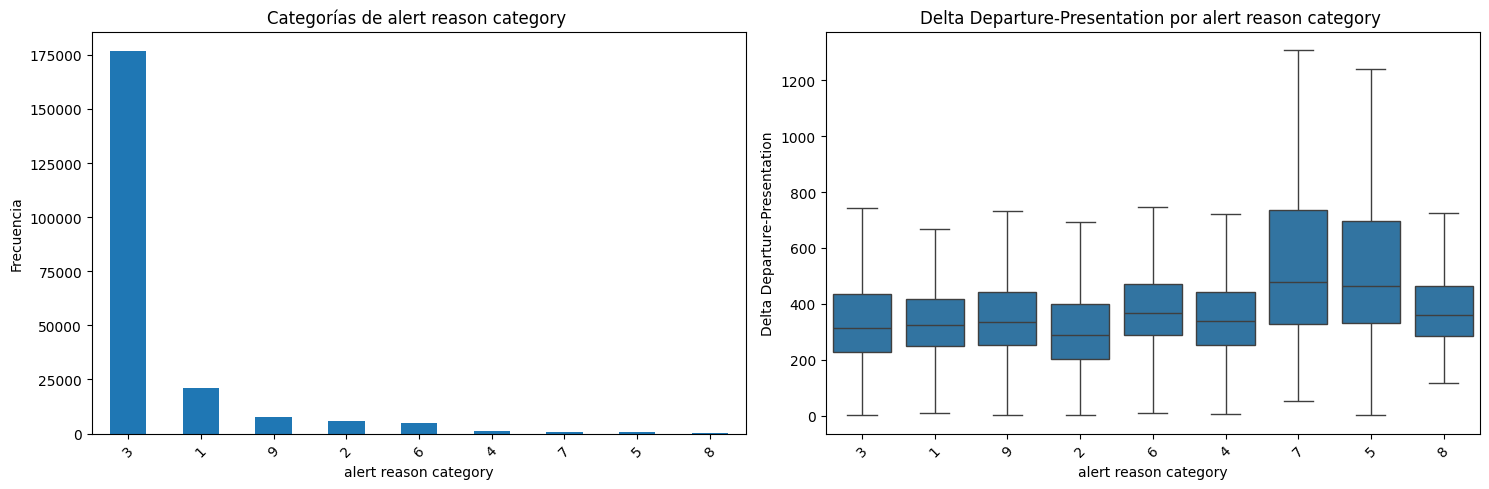

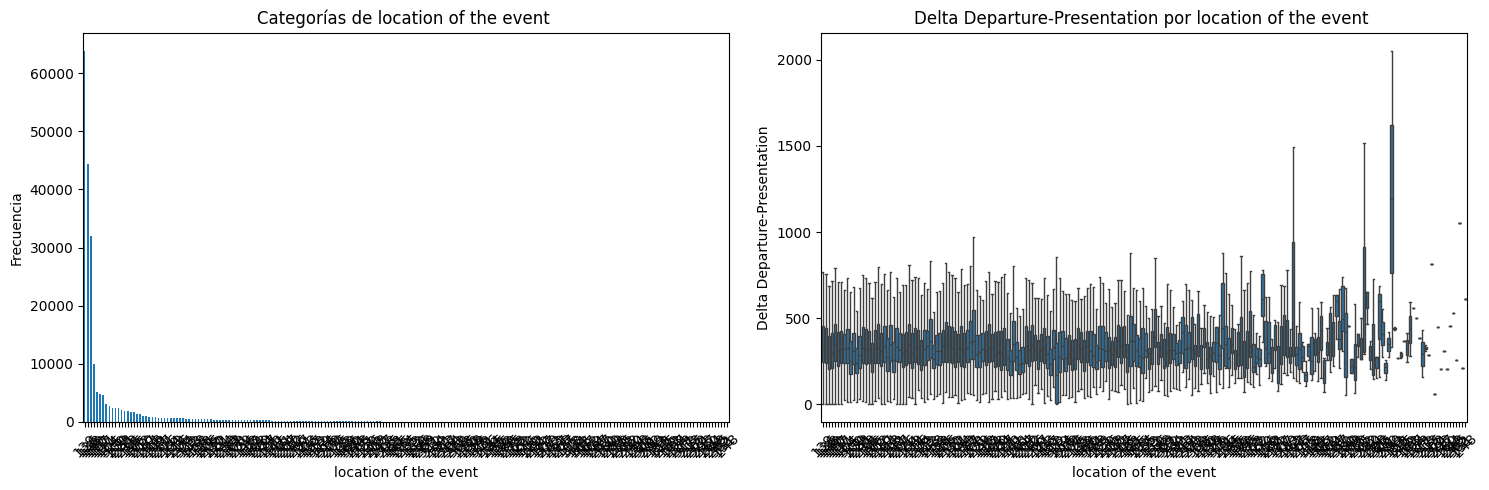

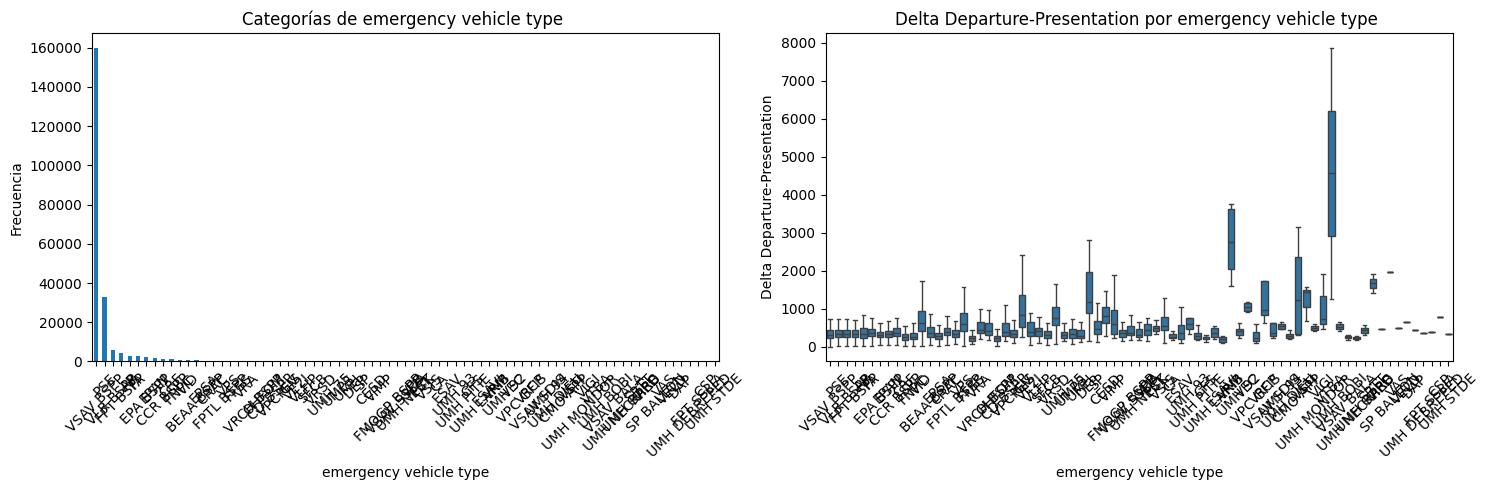

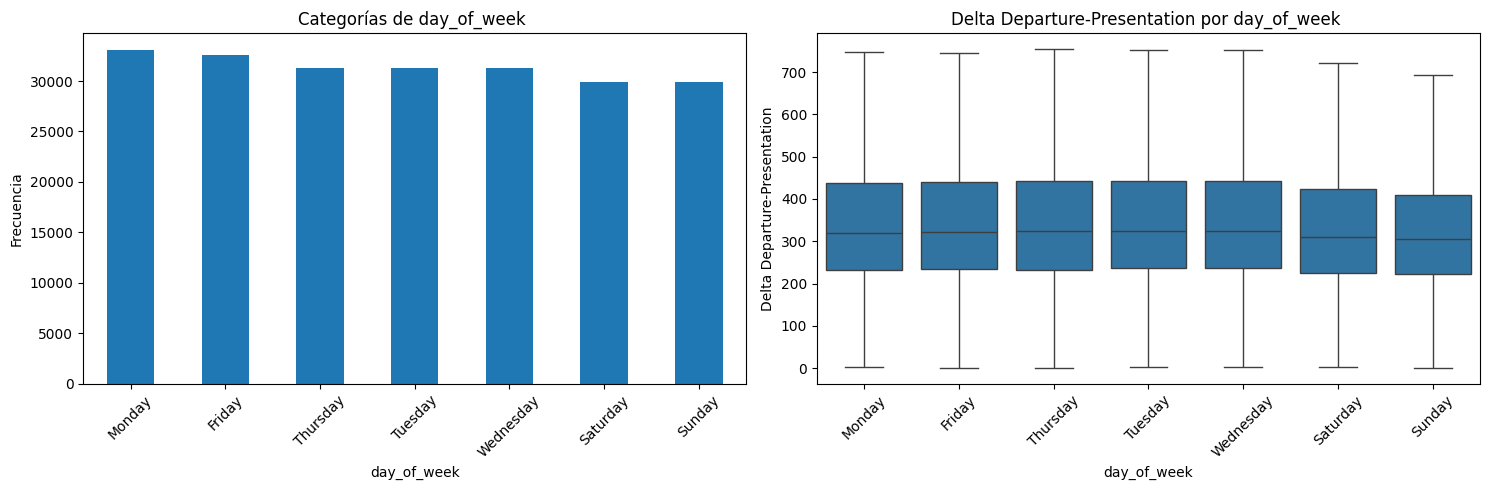

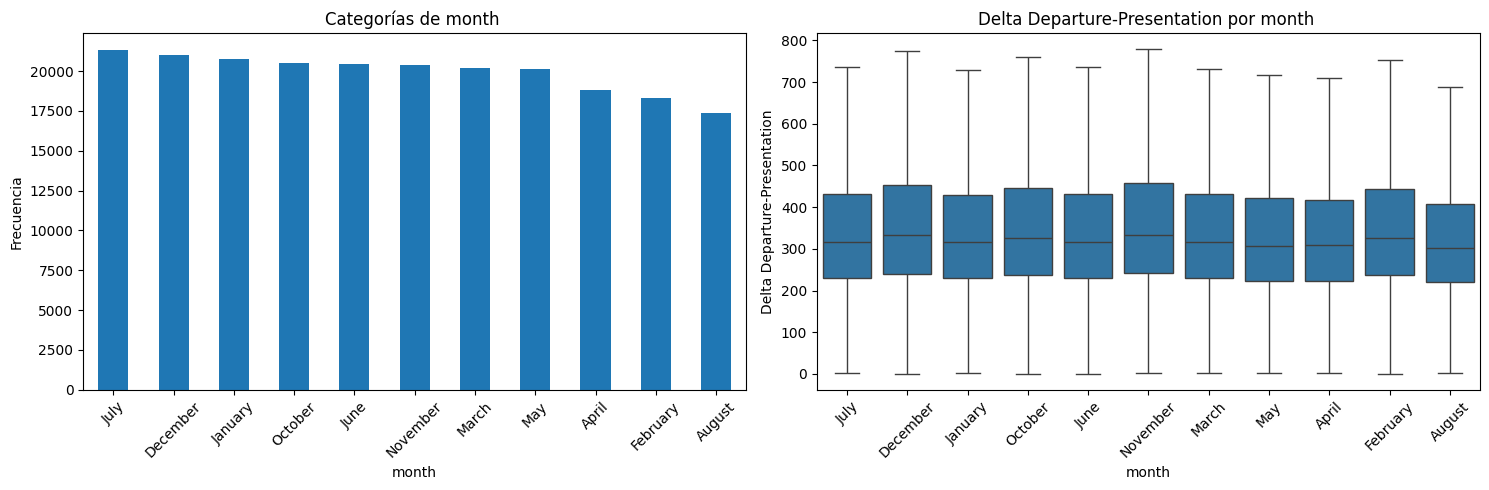

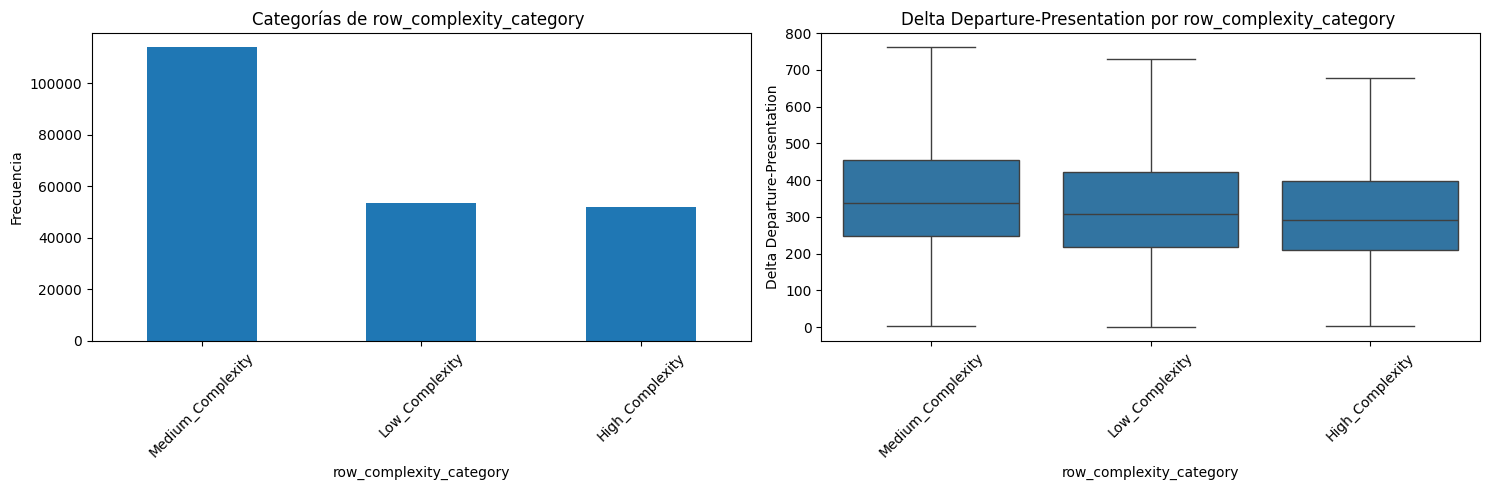

In [53]:
for col in categoricas_cols[:-1]:
    counts = df[col].value_counts()
    order = counts.index.tolist()

    fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # Create a figure with 1 row and 2 columns

    # Plot relative frequency
    counts.plot(kind='bar', ax=axes[0])
    axes[0].set_title(f'Categorías de {col} ')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frecuencia')
    axes[0].tick_params(axis='x', rotation=45)

    # Plot boxplot
    sns.boxplot(x=col, y='delta departure-presentation', data=df, showfliers=False, order=order, ax=axes[1])
    axes[1].set_title(f'Delta Departure-Presentation por {col} ')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Delta Departure-Presentation')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


¿Vale la pena considerar todas las categorias para el one hot encodig?

In [54]:
len(df)*0.001

219.33700000000002

In [55]:
min_frec = len(df)*0.001

for col in categoricas_cols:
  counts = df[col].value_counts()
  cat_frecuentes = counts[counts >= min_frec]
  print(f"{len(cat_frecuentes):2} de {df[col].nunique():3} categorias cumplen con la frec minima en '{col}'")

 9 de   9 categorias cumplen con la frec minima en 'alert reason category'
65 de 210 categorias cumplen con la frec minima en 'location of the event'
16 de  75 categorias cumplen con la frec minima en 'emergency vehicle type'
 7 de   7 categorias cumplen con la frec minima en 'day_of_week'
11 de  11 categorias cumplen con la frec minima en 'month'
 3 de   3 categorias cumplen con la frec minima en 'row_complexity_category'
73 de 3820 categorias cumplen con la frec minima en 'starting_point'


In [56]:
encoder = OneHotEncoder(handle_unknown='ignore',
                        sparse_output=False,
                        min_frequency=.001,   # las categorías que cumplan la condición serán agurpadas en un solo grupo de categorías infrecuentes.
                        drop='first')
encoder.fit(df[categoricas_cols]).set_output(transform = 'pandas')
he = encoder.transform(df[categoricas_cols])
len(he.columns)

180

In [57]:
df.shape, he.shape

((219337, 14), (219337, 180))

In [58]:
df = df.drop(columns=categoricas_cols)
df = pd.concat([df, he], axis=1)
#Llevar la etiqueta hasta la ultima posición
df = df[[c for c in df if c != 'delta departure-presentation'] + ['delta departure-presentation']]
df.shape

(219337, 187)

# Modelo de Regresión

In [60]:
y = df['delta departure-presentation']
X = df.drop([ 'delta departure-presentation'], axis=1)

In [ ]:
# Línea base (error medio absoluto)
ema_base = np.mean(np.absolute(y - y.mean()))
print(f"""
El error de predecir el promedio del tiempo de respuesta,
sin usar las caracteristicas explicativas (X) es {ema_base:.2f}
      """)


El error de predecir el promedio del tiempo de respuesta,
sin usar las caracteristicas explicativas (X) es 136.87
      


## Regresión Lineal

Evaluaremos al modelo de regresión líneal asegurandonos que el resultado sea robusto

In [66]:
from sklearn.model_selection import KFold, cross_validate, GridSearchCV

cv = KFold(n_splits=10, shuffle=True, random_state=42)
model = LinearRegression()
cv_results = cross_validate(
    estimator=model,
    X=X,
    y=y,
    cv=cv,
    return_train_score=True,
    return_estimator=True,
    scoring='neg_mean_absolute_error',  # el algoritmo de optimización que usa sklearn maximisa este valor.
)

In [67]:
# cambiamos el signo para obtener MAE
df_scores = pd.DataFrame({'train_score': -cv_results['train_score'],
                          'test_score': -cv_results['test_score']
                          })
df_scores

,train_score,test_score
0,105.018875,104.167496
1,104.961446,104.747016
2,104.993014,104.799665
3,104.876488,104.901107
4,104.998056,104.898893
5,104.914440,104.902580
6,105.006727,104.126740
7,104.906214,105.189594
8,104.929291,104.814134
9,104.568967,107.623353


In [68]:
print("\nMean cross-validation MAE:", df_scores['test_score'].mean())
print("Standard deviation of cross-validation MAE:", df_scores['test_score'].std())


Mean cross-validation MAE: 105.0170578571013
Standard deviation of cross-validation MAE: 0.974042978052489


<h2> Análisis de errores

Tenemos dos tipos de errores:


 1) Cuando la predicción es más baja que el valor real  $ ~~~~ y > \hat{y} $

 2) Cuando la predicción es más alta que el valor real $ ~~~~ y < \hat{y} $



In [70]:
errores = []
for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_test_fold = X.iloc[test_index]
    y_test_fold = y.iloc[test_index]

    model = cv_results['estimator'][i]
    y_pred_fold = model.predict(X_test_fold)
    errores_fold = (y_test_fold - y_pred_fold)
    errores.extend( errores_fold)

errores = np.array(errores)

len(errores), len (y)  # ahora tenemos un error de predicción para cada y

(219337, 219337)

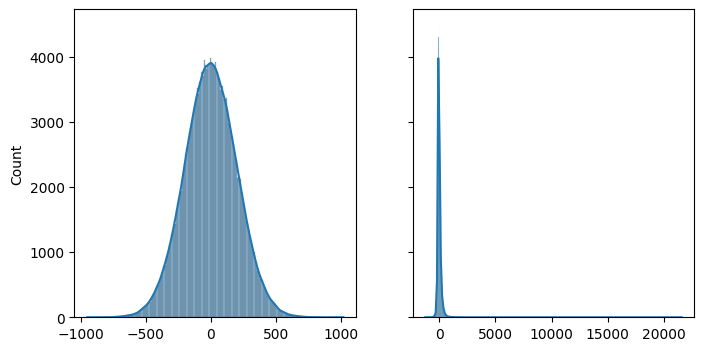

In [71]:
media = np.mean(errores)
des_est = np.std(errores)
errores_teoricos = np.random.normal(media, des_est, 219337)


fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for dat, subplot in zip((errores_teoricos, errores), ax.flatten()):
    sns.histplot(x=dat, ax=subplot, kde=True )

plt.show()

In [ ]:
print(f'kurtosis: {kurtosis(errores)}')

kurtosis: 1712.7296352451615


In [72]:
print(f'kurtosis: {kurtosis(errores_teoricos)}')

kurtosis: 0.03366249726940662


<font size="+1"><b> Notas para producción:</b></font>

Después de evaluar el modelo de regresión lineal, si quisieramos ponerlo en producción  ¿qué tendríamos que hacer si tenemos 10 modelos entrenados para cada una de las particiones?

## Regresión Robusta

## Búsqueda de hiperparámetros
<p align="center">
<img src="https://drive.google.com/uc?id=1Aly6q5OLZ6_blCHKJuKwxHQCQ2CKyFli
" width="576" height="404">
</p>








In [ ]:
%%time
cv_grid = KFold(n_splits=5, shuffle=True, random_state=42)

model_hr = HuberRegressor(max_iter=1000,  alpha=0,  warm_start=True,
                          fit_intercept=False, tol=1e-05)

model_grid_search = GridSearchCV(estimator=model_hr,
                           param_grid={
                               'epsilon':[1.25, 1.35, 1.5]  # Se recomienda un rango entre 1 y 2
                           },
                           scoring='neg_mean_absolute_error',
                           cv= cv_grid,   # estrategia de separación del conjunto de datos
                           verbose=3,
                              , # Al final entrena el modelo con los mejores parametros en todos los datos
                           )
cv = KFold(n_splits=3, shuffle=True, random_state=6)
cv_results = cross_validate(
    estimator=model_grid_search,
    X=X,
    y=y,
    cv=cv,
    #return_train_score=True,
    return_estimator=True,
    scoring='neg_mean_absolute_error',  # el algoritmo de optimización que usa sklearn maximisa este valor.
)




Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...................epsilon=1.25;, score=-104.267 total time=  26.5s
[CV 2/5] END ...................epsilon=1.25;, score=-102.580 total time= 1.6min
[CV 3/5] END ...................epsilon=1.25;, score=-105.211 total time=  24.1s
[CV 4/5] END ...................epsilon=1.25;, score=-103.934 total time=  18.4s
[CV 5/5] END ...................epsilon=1.25;, score=-103.552 total time=  39.7s
[CV 1/5] END ...................epsilon=1.35;, score=-103.092 total time=  51.0s
[CV 2/5] END ...................epsilon=1.35;, score=-102.700 total time= 1.2min
[CV 3/5] END ...................epsilon=1.35;, score=-105.351 total time=  20.3s
[CV 4/5] END ...................epsilon=1.35;, score=-102.451 total time= 1.1min
[CV 5/5] END ...................epsilon=1.35;, score=-102.840 total time= 1.5min
[CV 1/5] END ....................epsilon=1.5;, score=-105.927 total time=  19.1s
[CV 2/5] END ....................epsilon=1.5;, sc

In [ ]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'epsilon': 1.35}
Best hyperparameters for fold #2:
{'epsilon': 1.5}
Best hyperparameters for fold #3:
{'epsilon': 1.35}


In [ ]:
df_scores = pd.DataFrame({'test_score': -cv_results['test_score']
                          })
df_scores

,test_score
0,101.363569
1,102.416016
2,103.008330


In [ ]:
print("Mean cross-validation MAE:", df_scores['test_score'].mean())
print("Standard deviation of cross-validation MAE:", df_scores['test_score'].std())

Mean cross-validation MAE: 102.26263816926568
Standard deviation of cross-validation MAE: 0.8330387367220138


In [ ]:
errores = []
for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_test_fold = X.iloc[test_index]
    y_test_fold = y.iloc[test_index]

    model = cv_results['estimator'][i]
    y_pred_fold = model.predict(X_test_fold)
    errores_fold = (y_test_fold - y_pred_fold)
    errores.extend( errores_fold)

errores = np.array(errores)

len(errores), len (y)  # ahora tenemos un error de predicción para cada y

(219337, 219337)

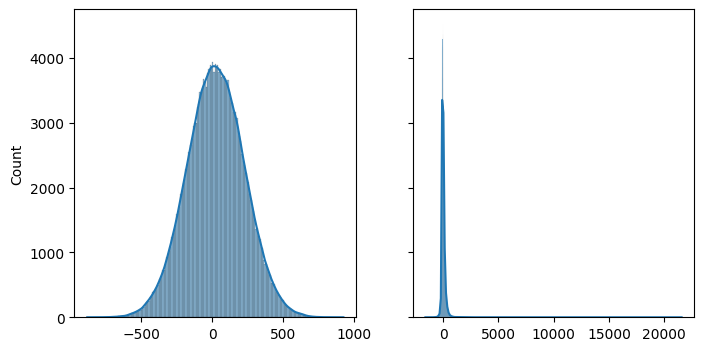

In [ ]:
media = np.mean(errores)
des_est = np.std(errores)
errores_teoricos = np.random.normal(media, des_est, 219337)


fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for dat, subplot in zip((errores_teoricos, errores), ax.flatten()):
    sns.histplot(x=dat, ax=subplot, kde=True )

plt.show()

In [ ]:
print(f'kurtosis: {kurtosis(errores)}')

kurtosis: 1640.9312074985849


In [ ]:
# Para producción utilizaremos el mejor modelo con los hiperparametros optimizados
# entrenado con todos los datos etiquetados disponibles.

modelo_final = HuberRegressor(alpha=0, epsilon=1.35, fit_intercept=False, max_iter=1000,
               warm_start=True).fit(X, y)

In [ ]:
coeficientes_df = pd.DataFrame({'Característica': X.columns, 'Coeficiente': modelo_final.coef_})
coeficientes_df.sort_values(by='Coeficiente', ascending=False, inplace=True)
coeficientes_df


,Característica,Coeficiente
1,departed from its rescue center,104.612635
10,alert reason category_6,40.224877
88,emergency vehicle type_FPT BSPP,36.216429
90,emergency vehicle type_PSE,35.422443
109,month_November,31.313608
...,...,...
141,starting_point_48.8476_2.3843,-13.408216
132,starting_point_48.8305_2.5581,-13.472583
123,starting_point_48.7966_2.5022,-13.813519
122,starting_point_48.7919_2.3529,-18.323432


# Regresión Polinomial

In [61]:
X_estandarizados = X.copy()
columnas = X.columns

scaler = StandardScaler()

X_estandarizados[columnas] = scaler.fit_transform(X[columnas])
X_estandarizados.describe()

,intervention on public roads,departed from its rescue center,OSRM estimated distance,weekend,rush hour,is_holiday,alert reason category_2,alert reason category_3,alert reason category_4,alert reason category_5,...,starting_point_48.9282_2.388,starting_point_48.9293_2.3014,starting_point_48.9305_2.5463,starting_point_48.9432_2.4446,starting_point_48.9451_2.341,starting_point_48.9455_2.34,starting_point_48.9473_2.5149,starting_point_48.9522_2.368,starting_point_48.9657_2.5682,starting_point_infrequent_sklearn
count,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,...,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05
mean,3.602327e-17,2.647321e-16,5.312784e-17,-5.818146e-17,-2.954426e-17,-2.847523e-17,-3.242742e-17,1.058669e-16,-4.353891e-17,1.665104e-17,...,-6.608585e-18,-5.539549e-18,-2.963335e-17,-3.673596e-17,-3.242742e-17,-6.867745e-18,2.679068e-17,7.774806e-19,2.980342e-18,-5.183204e-19
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-4.143257e-01,-6.613264e+00,-1.405675e+00,-6.124556e-01,-4.785960e-01,-1.665940e-01,-1.634160e-01,-2.038334e+00,-7.481937e-02,-5.977838e-02,...,-1.129296e-01,-1.123484e-01,-7.119006e-02,-7.930934e-02,-1.385139e-01,-3.175843e-02,-1.214071e-01,-8.585713e-02,-7.323158e-02,-1.555552e-01
25%,-4.143257e-01,1.512113e-01,-6.389835e-01,-6.124556e-01,-4.785960e-01,-1.665940e-01,-1.634160e-01,4.905967e-01,-7.481937e-02,-5.977838e-02,...,-1.129296e-01,-1.123484e-01,-7.119006e-02,-7.930934e-02,-1.385139e-01,-3.175843e-02,-1.214071e-01,-8.585713e-02,-7.323158e-02,-1.555552e-01
50%,-4.143257e-01,1.512113e-01,-2.333023e-01,-6.124556e-01,-4.785960e-01,-1.665940e-01,-1.634160e-01,4.905967e-01,-7.481937e-02,-5.977838e-02,...,-1.129296e-01,-1.123484e-01,-7.119006e-02,-7.930934e-02,-1.385139e-01,-3.175843e-02,-1.214071e-01,-8.585713e-02,-7.323158e-02,-1.555552e-01
75%,-4.143257e-01,1.512113e-01,3.747483e-01,1.632771e+00,-4.785960e-01,-1.665940e-01,-1.634160e-01,4.905967e-01,-7.481937e-02,-5.977838e-02,...,-1.129296e-01,-1.123484e-01,-7.119006e-02,-7.930934e-02,-1.385139e-01,-3.175843e-02,-1.214071e-01,-8.585713e-02,-7.323158e-02,-1.555552e-01
max,2.413560e+00,1.512113e-01,2.545460e+01,1.632771e+00,2.089445e+00,6.002616e+00,6.119350e+00,4.905967e-01,1.336552e+01,1.672846e+01,...,8.855077e+00,8.900881e+00,1.404691e+01,1.260885e+01,7.219494e+00,3.148770e+01,8.236747e+00,1.164726e+01,1.365531e+01,6.428585e+00


In [68]:
# Eliminar columnas relacionadas con 'location of the event' para disminuir la dimensionalidad


cols_out = [col for col in X.columns if col.startswith('starting_point') or    \
            col.startswith('location of the event')]
cols_to_keep = [col for col in X.columns if col not in cols_out]
len(cols_to_keep)

48

In [69]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree=2, interaction_only=True).set_output(transform='pandas')
X_poly= polynomial_features.fit_transform(X_estandarizados[cols_to_keep])
X_poly.shape

(219337, 1177)

In [70]:
Xpoly_train, Xpoly_test, y_train, y_test = train_test_split(X_poly, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=261)

In [71]:
reg_poli = LinearRegression().fit(Xpoly_train, y_train)

y_pred = reg_poli.predict(Xpoly_test)

error_medio_absoluto = np.mean(np.absolute(y_test - y_pred ))
error_medio_absoluto

np.float64(105.97689881535277)

# Referencias

* García, S., Luengo, J., & Herrera, F. (2015). Data Preprocessing in Data Mining. Intelligent Systems Reference Library. doi:10.1007/978-3-319-10247-4


* Hawkins, D. M. (1980). Identification of Outliers. Springer Netherlands. https://doi.org/10.1007/978-94-015-3994-4


* McDonald, A. (2021, septiembre 8). Using the missing Python library to Identify and Visualise Missing Data Prior to Machine Learning. Medium. https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

* Chandrashekar, G., & Sahin, F. (2014). A survey on feature selection methods. Computers & Electrical Engineering, 40(1), 16-28. https://doi.org/10.1016/j.compeleceng.2013.11.024


.


